# Remote Trainer for Distributed TrackMania PPO

This notebook runs on Colab and handles:
1. Flask HTTP server for receiving episodes and serving actions
2. Policy and Critic networks on GPU
3. PPO training algorithm
4. Model checkpoints

**Instructions:**
1. Get your ngrok authtoken from https://dashboard.ngrok.com/get-started/your-authtoken
2. Run all cells in order
3. Copy the ngrok URL from the output
4. Use that URL when running `local_trainer.py` on your local machine

## Cell 1: Setup & Imports

In [2]:
# Install dependencies
!pip install flask pyngrok

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from flask import Flask, request, jsonify, Response
import pickle
import gzip
import threading
import time
from pyngrok import ngrok
import os

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: Tesla T4
Using device: cuda


## Cell 2: Configure ngrok Authentication

**IMPORTANT:** Paste your ngrok authtoken below.

Get it from: https://dashboard.ngrok.com/get-started/your-authtoken

In [3]:
# Set your ngrok authtoken here
NGROK_AUTH_TOKEN = "35xBBvGUDWL6EDycZMAqqvPyWrP_4xjVrQ43seS6sNk4hxdxx"  

# Configure ngrok
ngrok.set_auth_token(NGROK_AUTH_TOKEN)
print("✓ ngrok authtoken configured")

✓ ngrok authtoken configured                                                                        


## Cell 3: Hyperparameters & Model Definitions

In [4]:
# Hyperparameters (from trackmaster.ipynb)
# hyper_params = {
#     'policy_lr': 1e-5,
#     'critic_lr': 1e-5,
#     'gamma': 0.996,
#     'clip_coef': 0.2,
#     'critic_coef': 0.1,
#     'entropy_coef': 0.1,
#     'batch_size': 256,
#     'num_updates': 10000,
#     'epochs_per_update': 100,
#     'hidden_dim': 512,
#     'max_episode_steps': 2400,
#     'norm_advantages': True,
#     'grad_clip_val': 0.1,
#     'initial_std': 1,
#     'avg_ray': 400
# }

hyper_params = {
      'policy_lr': 3e-4,      # Higher LR for tiny model
      'critic_lr': 3e-4,
      'gamma': 0.996,
      'clip_coef': 0.2,
      'critic_coef': 0.1,
      'entropy_coef': 0.1,
      'batch_size': 128,      # Smaller batch
      'num_updates': 10000,
      'epochs_per_update': 50,  # Fewer epochs = faster
      'hidden_dim': 32,       # KEY CHANGE: 512 → 32
      'max_episode_steps': 2400,
      'norm_advantages': True,
      'grad_clip_val': 0.5,
      'initial_std': 1,
      'avg_ray': 400
  }

observation_space = 49161  
action_space = 3  # Steering, throttle, brake

print(f"Observation space: {observation_space}")
print(f"Action space: {action_space}")
print(f"Hyperparameters: {hyper_params}")

Observation space: 49161
Action space: 3
Hyperparameters: {'policy_lr': 0.0003, 'critic_lr': 0.0003, 'gamma': 0.996, 'clip_coef': 0.2, 'critic_coef': 0.1, 'entropy_coef': 0.1, 'batch_size': 128, 'num_updates': 10000, 'epochs_per_update': 50, 'hidden_dim': 32, 'max_episode_steps': 2400, 'norm_advantages': True, 'grad_clip_val': 0.5, 'initial_std': 1, 'avg_ray': 400}


In [5]:
# Helper function to convert observation tuple to tensor
def env_obs_to_tensor(observations):
    """Convert TMRL observation tuple to flattened tensor"""
    tensors = [torch.tensor(observation, dtype=torch.float32).view(-1) for observation in observations]
    return torch.cat(tuple(tensors), dim=-1)

# Policy Network
class Policy(nn.Module):
    def __init__(self):
        super().__init__()
        self.action_mean = nn.Sequential(
            nn.Linear(observation_space, hyper_params['hidden_dim']),
            nn.ReLU(),
            nn.Linear(hyper_params['hidden_dim'], hyper_params['hidden_dim']),
            nn.ReLU(),
            nn.Linear(hyper_params['hidden_dim'], action_space),
            nn.Tanh()
        )

        self.actor_logvar = nn.Sequential(
            nn.Linear(observation_space, hyper_params['hidden_dim']),
            nn.ReLU(),
            nn.Linear(hyper_params['hidden_dim'], hyper_params['hidden_dim']),
            nn.ReLU(),
            nn.Linear(hyper_params['hidden_dim'], 1)
        )

    def sample_action_with_logprobs(self, observation):
        dist = self(observation)
        sample_action = dist.sample()
        return sample_action, dist.log_prob(sample_action)

    def mean_only(self, observation):
        with torch.no_grad():
            return self.action_mean(observation)

    def get_action_log_prob(self, observation, action):
        dist = self(observation)
        return dist.log_prob(action)

    def forward(self, observation):
        observation = observation / hyper_params['avg_ray']
        means = self.action_mean(observation)
        vars = torch.zeros(observation.shape[0], action_space).to(device)
        vars[:, :] = self.actor_logvar(observation).exp().view(-1, 1)
        covar_mat = torch.zeros(observation.shape[0], action_space, action_space).to(device)
        covar_mat[:, np.arange(action_space), np.arange(action_space)] = vars

        dist = torch.distributions.MultivariateNormal(means, covar_mat)
        return dist

# Critic Network
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(observation_space, hyper_params['hidden_dim']),
            nn.ReLU(),
            nn.Linear(hyper_params['hidden_dim'], hyper_params['hidden_dim']),
            nn.ReLU(),
            nn.Linear(hyper_params['hidden_dim'], 1)
        )

    def forward(self, observation):
        observation = observation / hyper_params['avg_ray']
        return self.network(observation)

# Agent (combines Policy and Critic)
class Agent(nn.Module):
    def __init__(self):
        super().__init__()
        self.policy = Policy()
        self.critic = Critic()

    def forward(self, x):
        raise SyntaxError('Propagate through Agent.policy and Agent.critic individually')

print("✓ Model classes defined")

✓ Model classes defined


## Cell 4: Initialize Models & Optimizers

In [6]:
# Initialize agent
agent = Agent().to(device)
policy_optim = torch.optim.Adam(agent.policy.parameters(), lr=hyper_params['policy_lr'])
critic_optim = torch.optim.Adam(agent.critic.parameters(), lr=hyper_params['critic_lr'])

# Training state
training_lock = threading.Lock()
is_training = False
update_count = 0
training_history = []

# Checkpoint directory
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

print(f"✓ Agent initialized on {device}")
print(f"  Policy parameters: {sum(p.numel() for p in agent.policy.parameters()):,}")
print(f"  Critic parameters: {sum(p.numel() for p in agent.critic.parameters()):,}")

✓ Agent initialized on cuda
  Policy parameters: 3,148,612
  Critic parameters: 1,574,273


## Cell 5: Training Function

In [7]:
def train_on_episode(episode_data):
    """Train PPO for multiple epochs on one episode"""
    global is_training, update_count, training_history

    with training_lock:
        try:
            is_training = True

            print(f"\n{'='*60}")
            print(f"Training Update {update_count + 1}")
            print(f"{'='*60}")

            episode_length = episode_data['episode_length']
            episode_reward = episode_data['episode_reward']

            print(f"  Episode length: {episode_length} steps")
            print(f"  Episode reward: {episode_reward:.2f}")

            # Extract episode data
            observations = episode_data['observations']
            actions = torch.tensor(np.array(episode_data['actions']), dtype=torch.float32)
            old_logprobs = torch.tensor(episode_data['logprobs'], dtype=torch.float32)
            rewards = torch.tensor(episode_data['rewards'], dtype=torch.float32)
            state_values = torch.tensor(episode_data['state_values'], dtype=torch.float32)

            # Compute returns (discounted cumulative rewards)
            returns = torch.zeros(episode_length)
            with torch.no_grad():
                for t in range(episode_length - 1, -1, -1):
                    if t == episode_length - 1:
                        returns[t] = rewards[t]
                    else:
                        returns[t] = rewards[t] + hyper_params['gamma'] * returns[t + 1]

                # Compute advantages
                advantages = returns - state_values

            print(f"  Mean advantage: {advantages.mean():.4f}")
            print(f"  Mean return: {returns.mean():.4f}")

            # Training metrics
            epoch_actor_losses = []
            epoch_critic_losses = []
            epoch_total_losses = []

            # Set models to training mode
            agent.train()

            # Train for multiple epochs
            for epoch in range(hyper_params['epochs_per_update']):
                # Random permutation for mini-batches
                rand_idxs = np.random.permutation(episode_length)

                # Mini-batch updates
                for batch_start in range(0, episode_length, hyper_params['batch_size']):
                    batch_end = min(batch_start + hyper_params['batch_size'], episode_length)
                    batch_idxs = rand_idxs[batch_start:batch_end]

                    # Extract batch
                    batch_obs = [observations[i] for i in batch_idxs]
                    batch_obs_tensor = torch.stack([env_obs_to_tensor(obs) for obs in batch_obs]).to(device)
                    batch_actions = actions[batch_idxs].to(device)
                    batch_old_logprobs = old_logprobs[batch_idxs].to(device)
                    batch_returns = returns[batch_idxs].to(device)
                    batch_advantages = advantages[batch_idxs].to(device)

                    # Normalize advantages
                    if hyper_params['norm_advantages']:
                        batch_advantages = (batch_advantages - batch_advantages.mean()) / (batch_advantages.std() + 1e-8)

                    # ========== PPO Actor Loss ==========
                    # Get new log probabilities
                    batch_new_logprobs = agent.policy.get_action_log_prob(batch_obs_tensor, batch_actions)

                    # Importance sampling ratio
                    log_ratio = batch_new_logprobs - batch_old_logprobs
                    ratio = torch.exp(log_ratio)

                    # PPO clipped surrogate objective
                    unclipped_obj = -ratio * batch_advantages
                    clipped_obj = -torch.clamp(
                        ratio,
                        1 - hyper_params['clip_coef'],
                        1 + hyper_params['clip_coef']
                    ) * batch_advantages
                    ppo_loss = torch.max(unclipped_obj, clipped_obj).sum() / len(batch_idxs)

                    # ========== Critic Loss ==========
                    new_values = agent.critic(batch_obs_tensor).squeeze()
                    v_loss = ((new_values - batch_returns) ** 2).sum() / len(batch_idxs)

                    # ========== Combined Loss ==========
                    total_loss = ppo_loss + hyper_params['critic_coef'] * v_loss

                    # ========== Optimization ==========
                    policy_optim.zero_grad()
                    critic_optim.zero_grad()

                    total_loss.backward()

                    # Gradient clipping
                    nn.utils.clip_grad_value_(agent.policy.parameters(), clip_value=hyper_params['grad_clip_val'])

                    # Handle NaN gradients
                    for param in agent.policy.parameters():
                        if param.grad is not None:
                            mask = torch.isnan(param.grad)
                            param.grad[mask] = 0.0

                    nn.utils.clip_grad_value_(agent.critic.parameters(), clip_value=hyper_params['grad_clip_val'])

                    policy_optim.step()
                    critic_optim.step()

                    # Record losses
                    epoch_actor_losses.append(ppo_loss.item())
                    epoch_critic_losses.append(v_loss.item())
                    epoch_total_losses.append(total_loss.item())

                # Print progress every 20 epochs
                if (epoch + 1) % 20 == 0:
                    print(f"    Epoch {epoch + 1}/{hyper_params['epochs_per_update']} - Loss: {np.mean(epoch_total_losses[-10:]):.4f}")

            # Update statistics
            update_count += 1

            metrics = {
                'update': int(update_count),
                'reward': float(episode_reward),
                'steps': int(episode_length),
                'actor_loss': float(np.mean(epoch_actor_losses)),
                'critic_loss': float(np.mean(epoch_critic_losses)),
                'total_loss': float(np.mean(epoch_total_losses))
            }
            training_history.append(metrics)

            print(f"\n  Training complete:")
            print(f"    Actor loss: {metrics['actor_loss']:.4f}")
            print(f"    Critic loss: {metrics['critic_loss']:.4f}")
            print(f"    Total loss: {metrics['total_loss']:.4f}")

            # Save checkpoint if good reward
            if episode_reward > 200:
                checkpoint_name = f"Y{episode_reward:.2f}RewardRacer{update_count}Update.pt"
                checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
                torch.save(agent.state_dict(), checkpoint_path)
                print(f"  ✓ Checkpoint saved: {checkpoint_name}")

            # Periodic checkpoint
            if update_count % 50 == 0:
                checkpoint_name = f"checkpoint_update{update_count}.pt"
                checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
                torch.save({
                    'agent_state_dict': agent.state_dict(),
                    'policy_optim_state_dict': policy_optim.state_dict(),
                    'critic_optim_state_dict': critic_optim.state_dict(),
                    'update_count': update_count,
                    'training_history': training_history
                }, checkpoint_path)
                print(f"  ✓ Periodic checkpoint saved: {checkpoint_name}")

        except Exception as e:
            print(f"\n✗ Training failed with error:")
            print(f"  {type(e).__name__}: {e}")
            import traceback
            traceback.print_exc()

        finally:
            # CRITICAL: Always reset training state, even if exception occurs
            is_training = False
            print(f"{'='*60}\n")

print("✓ Training function defined")

✓ Training function defined


## Cell 6: Flask Server & Endpoints

In [8]:
# Create Flask app
app = Flask(__name__)

@app.route('/reset', methods=['POST'])
def reset_episode():
    """Signal that new episode is starting"""
    return jsonify({'status': 'ready'}), 200

@app.route('/action', methods=['POST'])
def get_action():
    """Receive observation and return action"""
    try:
        # Deserialize observation
        observation = pickle.loads(request.data)

        # Convert to tensor
        obs_tensor = env_obs_to_tensor(observation).unsqueeze(0).to(device)

        # Get action from policy
        agent.eval()
        with torch.no_grad():
            action, logprob = agent.policy.sample_action_with_logprobs(obs_tensor)
            state_value = agent.critic(obs_tensor)

        # Return action, logprob, state_value
        result = {
            'action': action[0].cpu().numpy(),
            'logprob': logprob[0].cpu().item(),
            'state_value': state_value[0].cpu().item()
        }

        return Response(pickle.dumps(result), mimetype='application/octet-stream')

    except Exception as e:
        print(f"\n✗ Error in /action endpoint:")
        print(f"  {type(e).__name__}: {e}")
        import traceback
        traceback.print_exc()
        return jsonify({'error': str(e)}), 500

@app.route('/episode', methods=['POST'])
def receive_episode():
    """Receive episode data and start training"""
    try:
        # Decompress and deserialize
        compressed_data = request.data
        data = gzip.decompress(compressed_data)
        episode_data = pickle.loads(data)

        print(f"\n✓ Received episode: {episode_data['episode_length']} steps, reward={episode_data['episode_reward']:.2f}")

        # Start training in background thread
        training_thread = threading.Thread(target=train_on_episode, args=(episode_data,))
        training_thread.start()

        return jsonify({'status': 'training_started'}), 200

    except Exception as e:
        print(f"\n✗ Error in /episode endpoint:")
        print(f"  {type(e).__name__}: {e}")
        import traceback
        traceback.print_exc()
        return jsonify({'error': str(e)}), 500

@app.route('/status', methods=['GET'])
def check_status():
    """Health check and training status"""
    return jsonify({
        'status': 'training' if is_training else 'idle',
        'update_count': update_count,
        'latest_reward': training_history[-1]['reward'] if training_history else None
    })

print("✓ Flask server defined")

✓ Flask server defined


## Cell 7: Start Server with ngrok

In [9]:
# Start Flask server in background thread
def run_flask():
    app.run(host='0.0.0.0', port=5000, threaded=True)

server_thread = threading.Thread(target=run_flask, daemon=True)
server_thread.start()

# Wait for server to start
time.sleep(2)

# Create ngrok tunnel
public_url = ngrok.connect(5000)

# Extract the actual URL string from the NgrokTunnel object
url_string = public_url.public_url

print("="*60)
print("🚀 Remote Training Server Started!")
print("="*60)
print(f"\n📡 Server URL: {url_string}")
print("\n⚡ Use this URL when running local_trainer.py:\n")
print(f"   python local_trainer.py --remote-url {url_string} --num-updates 10000")
print("\n" + "="*60)
print("\n✓ Server is ready to receive episodes")
print("✓ Waiting for connections...\n")

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


🚀 Remote Training Server Started!

📡 Server URL: https://adalyn-unfallowed-brigida.ngrok-free.dev

⚡ Use this URL when running local_trainer.py:

   python local_trainer.py --remote-url https://adalyn-unfallowed-brigida.ngrok-free.dev --num-updates 10000


✓ Server is ready to receive episodes
✓ Waiting for connections...



## Cell 8: Monitoring Dashboard

Training Dashboard

Server Status: 🟢 Idle
Total Updates: 2

Latest Episode:
  Reward: 0.00
  Steps: 81
  Actor Loss: -0.0592
  Critic Loss: 0.0213


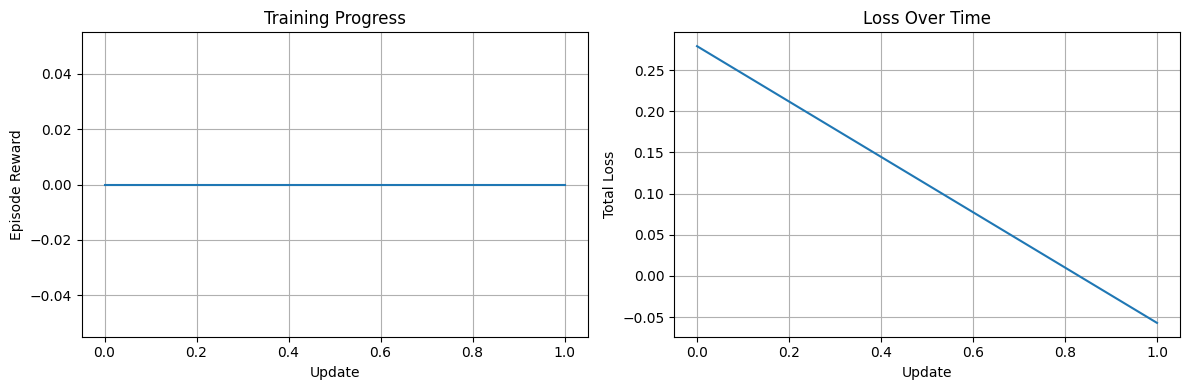



Refreshing in 10 seconds... (Ctrl+C to stop)


KeyboardInterrupt: 

In [10]:
# Run this cell to see training progress
import IPython.display as display

while True:
    display.clear_output(wait=True)

    print("="*60)
    print("Training Dashboard")
    print("="*60)
    print(f"\nServer Status: {'🔴 Training' if is_training else '🟢 Idle'}")
    print(f"Total Updates: {update_count}")

    if training_history:
        latest = training_history[-1]
        print(f"\nLatest Episode:")
        print(f"  Reward: {latest['reward']:.2f}")
        print(f"  Steps: {latest['steps']}")
        print(f"  Actor Loss: {latest['actor_loss']:.4f}")
        print(f"  Critic Loss: {latest['critic_loss']:.4f}")

        if len(training_history) >= 2:
            # Plot rewards
            rewards = [h['reward'] for h in training_history]
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 2, 1)
            plt.plot(rewards)
            plt.xlabel('Update')
            plt.ylabel('Episode Reward')
            plt.title('Training Progress')
            plt.grid(True)

            plt.subplot(1, 2, 2)
            losses = [h['total_loss'] for h in training_history]
            plt.plot(losses)
            plt.xlabel('Update')
            plt.ylabel('Total Loss')
            plt.title('Loss Over Time')
            plt.grid(True)

            plt.tight_layout()
            plt.show()

    else:
        print("\n⏳ Waiting for first episode...")

    print("\n" + "="*60)
    print("\nRefreshing in 10 seconds... (Ctrl+C to stop)")

    time.sleep(10)